In [161]:
import numpy as np
import moviepy.editor as mp
import opensmile
import pandas as pd
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import matplotlib
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score,classification_report
import joblib

In [2]:
hindidatafilepath = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi\\"
hindidatafilepathwav = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi_wav\\"
speakerID =  os.listdir(hindidatafilepath) #stores the speaker IDs

In [109]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [4]:
file_attitude = []
file_activation = [] #activation based classification
file_valence = [] #valence based classification
file_dominance = [] #dominance based classification
file_path = []
sentence_identity = []
speaker_identity = []
for fileDir in speakerID:
    for file in os.listdir(hindidatafilepathwav + fileDir+"\\"):
        file_path.append("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
        file_attitude.append(file[10:14]) #label of attitude 4 letter symbol
        sentence_identity.append(file[15]) #sentence labels could be 'a' and 'b'
        speaker_identity.append(file[0:3])
        #getting the activations based on attitudes from each utterance 3 (+1 - high, 0 - moderate, -1 - low)
        if file[10:14].lower() in ["admi", "surp", "arro", "cont", "irri"]:
            file_activation.append(1)#denotes high activation
        elif file[10:14].lower() in ["iron" , "sedu" , "auth" , "doub" , "unce"]:
            file_activation.append(0)
        else:
            file_activation.append(-1)

        if file[10:14].lower() in ["admi" , "surp", "sedu"]:
            file_valence.append("pos")
        elif file[10:14].lower() in ["decl", "ques", "poli", "sinc", "woeg"]:
            file_valence.append("neu")
        elif file[10:14].lower() in ["iron", "auth", "doub", "obvi"]:
            file_valence.append("mix")
        else:
            file_valence.append("neg")

        #dominance based classification
        if file[10:14].lower() in ["auth", "arro", "cont"]:
            file_dominance.append(1)
        elif file[10:14].lower() in ["poli", "decl", "ques", "sinc", "unce", "woeg"]:
            file_dominance.append(-1)
        else:
            file_dominance.append(0)


In [120]:
data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

KeyboardInterrupt: 

In [6]:
X = df.to_numpy() #no_of_samples x 88...no_of_samples = 512, 8 speakers, each has 16 attitudes and 2 sentences spoken twice per attitude

In [11]:
import importlib
import utils as utils
importlib.reload(utils)

#pwww = utils.load_wav_features("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav")
pwww = utils.load_wav_features("C:\\Users\\HP\\Downloads\\Ravdess\\audio_speech_actors_01-24")

In [19]:
pwww[2]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav',
 '03-01-02-01-01-02-01.wav',
 '03-01-02-01-02-01-01.wav',
 '03-01-02-01-02-02-01.wav',
 '03-01-02-02-01-01-01.wav',
 '03-01-02-02-01-02-01.wav',
 '03-01-02-02-02-01-01.wav',
 '03-01-02-02-02-02-01.wav',
 '03-01-03-01-01-01-01.wav',
 '03-01-03-01-01-02-01.wav',
 '03-01-03-01-02-01-01.wav',
 '03-01-03-01-02-02-01.wav',
 '03-01-03-02-01-01-01.wav',
 '03-01-03-02-01-02-01.wav',
 '03-01-03-02-02-01-01.wav',
 '03-01-03-02-02-02-01.wav',
 '03-01-04-01-01-01-01.wav',
 '03-01-04-01-01-02-01.wav',
 '03-01-04-01-02-01-01.wav',
 '03-01-04-01-02-02-01.wav',
 '03-01-04-02-01-01-01.wav',
 '03-01-04-02-01-02-01.wav',
 '03-01-04-02-02-01-01.wav',
 '03-01-04-02-02-02-01.wav',
 '03-01-05-01-01-01-01.wav',
 '03-01-05-01-01-02-01.wav',
 '03-01-05-01-02-01-01.wav',
 '03-01-05-01-02-02-01.wav',
 '03-01-05-02-01-01-01.wav',
 '03-01-05-02-01-02-01.wav',
 '03-01-05-02-

In [16]:
X

NameError: name 'X' is not defined

In [11]:
class StandardScaleNormalizer():

    def fit(self, X, speaker):
        """Fits the normalization on input data wrt each of the speaker

        Args:
            X (_type_): _description_
            y_attitude (_type_): _description_
            speaker (_type_): _description_
        """
        speakerID = set(speaker) #generates the unique speaker IDs
        dictMean, dictStd = {}, {}
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        for id in speakerID:
            df_speaker = df.loc[df["speakerID"] == id]
            df_speaker = df_speaker.drop(["speakerID"], axis = 1)
            dictMean[id] = df_speaker.mean()
            dictStd[id] = df_speaker.std()
            
        self.mean = dictMean
        self.scale = dictStd
        
    def transform(self, X, speaker):
        speakerID = set(speaker) #generates the unique speaker IDs
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        df_copy = df.copy()
        for id in speakerID:
            df_copy.loc[df_copy["speakerID"] == id] = (df_copy.loc[df_copy["speakerID"] == id]-self.mean[id])/self.scale[id]
        return df_copy.drop(["speakerID"], axis=1)

    def fit_transform(self, X, speaker):
        self.fit(X, speaker)
        df_copy = self.transform(X, speaker)
        return df_copy


In [12]:
normModel = StandardScaleNormalizer()
Xnorm = normModel.fit_transform(X, speaker_identity)

In [58]:
trained_savee_model_ensemble = []
model_path = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\"
for i in os.listdir(model_path):
    print("Loading model with {spk} left out in SAVEE".format(spk=i[-6:-4]))
    trained_savee_model_ensemble.append(joblib.load(model_path+i))

Loading model with DC left out in SAVEE
Loading model with JE left out in SAVEE
Loading model with JK left out in SAVEE
Loading model with KL left out in SAVEE


In [21]:
import importlib
import utils as utils
importlib.reload(utils)
trained_savee_model_ensemble = utils.load_svm_ensemble(model_path=r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\")

Loading model with DC left
Loading model with JE left
Loading model with JK left
Loading model with KL left


In [13]:
trained_savee_model_ensemble[0].predict(Xnorm)

array(['fear', 'neutral', 'angry', 'fear', 'disgust', 'angry', 'angry',
       'angry', 'disgust', 'angry', 'disgust', 'angry', 'sad', 'fear',
       'fear', 'disgust', 'disgust', 'neutral', 'neutral', 'disgust',
       'fear', 'fear', 'surprise', 'fear', 'happy', 'angry', 'disgust',
       'disgust', 'angry', 'angry', 'angry', 'surprise', 'fear', 'fear',
       'fear', 'disgust', 'neutral', 'angry', 'disgust', 'disgust',
       'surprise', 'fear', 'disgust', 'fear', 'disgust', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'fear', 'disgust',
       'surprise', 'surprise', 'surprise', 'fear', 'sad', 'disgust',
       'disgust', 'neutral', 'neutral', 'disgust', 'sad', 'neutral',
       'neutral', 'sad', 'fear', 'happy', 'angry', 'angry', 'happy',
       'fear', 'angry', 'angry', 'angry', 'happy', 'sad', 'angry',
       'disgust', 'disgust', 'neutral', 'neutral', 'neutral', 'disgust',
       'happy', 'angry', 'happy', 'surprise', 'sad', 'angry', 'disgust',
       'happy', 

<AxesSubplot:>

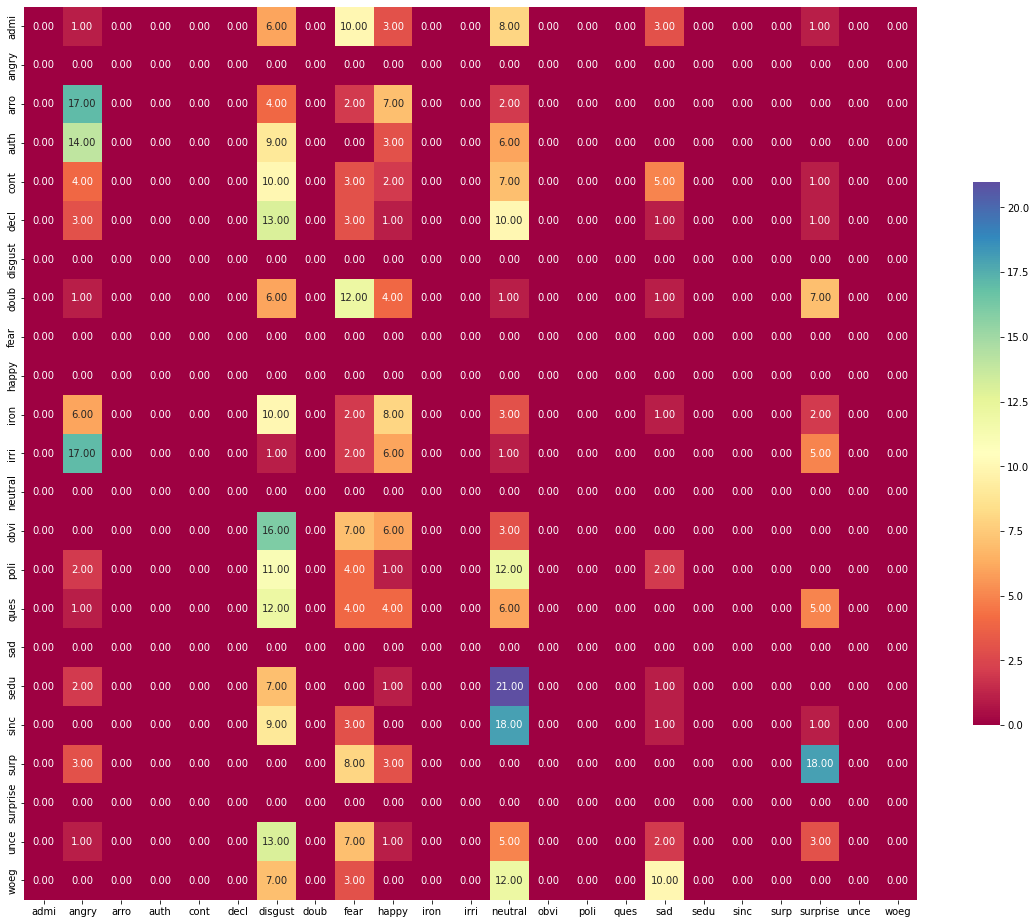

In [26]:
cm = confusion_matrix(file_attitude, trained_savee_model_ensemble[0].predict(Xnorm))
kk = np.sort(list(set(file_attitude)) + list(set(trained_savee_model_ensemble[0].predict(Xnorm))))
plt.figure(figsize=(20,20))

sns.heatmap(cm, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True,annot=True, fmt='.2f', xticklabels=kk, yticklabels=kk)

In [31]:
df_labels = pd.DataFrame()
df_labels["SAVEE Labels"] = file_attitude
for i in range(len(trained_savee_model_ensemble)):
    df_labels[f"Pred{i}"] = trained_savee_model_ensemble[i].predict(Xnorm)
df_final_please_god_im_done  = pd.crosstab(df_labels['SAVEE Labels'], df_labels['Pred0'])
for i in range(1, len(trained_savee_model_ensemble)):
    df_final_please_god_im_done += pd.crosstab(df_labels['SAVEE Labels'], df_labels[f'Pred{i}'])

In [32]:
df_final_please_god_im_done

Pred0,angry,disgust,fear,happy,neutral,sad,surprise
SAVEE Labels,,,,,,,
admi,10,27,33,13,18,18,9
arro,67,16,9,25,10,0,1
auth,55,35,4,16,17,0,1
cont,21,39,10,7,25,24,2
decl,11,56,10,3,31,16,1
doub,6,23,28,18,4,4,45
iron,26,42,6,30,11,5,8
irri,61,4,14,38,3,0,8
obvi,7,64,22,21,7,0,7


In [41]:
df_final_please_god_im_done.sum(axis=1)

SAVEE Labels
admi    128
arro    128
auth    128
cont    128
decl    128
doub    128
iron    128
irri    128
obvi    128
poli    128
ques    128
sedu    128
sinc    128
surp    128
unce    128
woeg    128
dtype: int64

<AxesSubplot:xlabel='Pred0', ylabel='SAVEE Labels'>

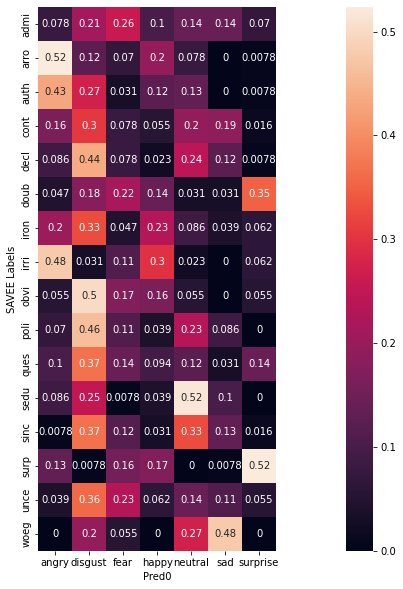

In [55]:
plt.figure(figsize=(25,10))
sns.heatmap(df_final_please_god_im_done/df_final_please_god_im_done.sum(axis=1)[:, np.newaxis],square= True, annot=True)

In [92]:
prob_sum = trained_savee_model_ensemble[0].predict_proba(Xnorm)
for i in range(1, 4):
    prob_sum+=trained_savee_model_ensemble[i].predict_proba(Xnorm)
prob_sum /=4.0

In [93]:
labels = np.sort(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
predictions = [labels[i] for i in np.argmax(prob_sum, axis=1)]

In [96]:
df_labels_new = pd.DataFrame()
df_labels_new["Hindi Attitude"] = file_attitude
df_labels_new["SAVEE Labels"] = predictions
df_labels_new_god_im_done_please_son_of_holyness = pd.crosstab(df_labels_new["Hindi Attitude"], df_labels_new["SAVEE Labels"])

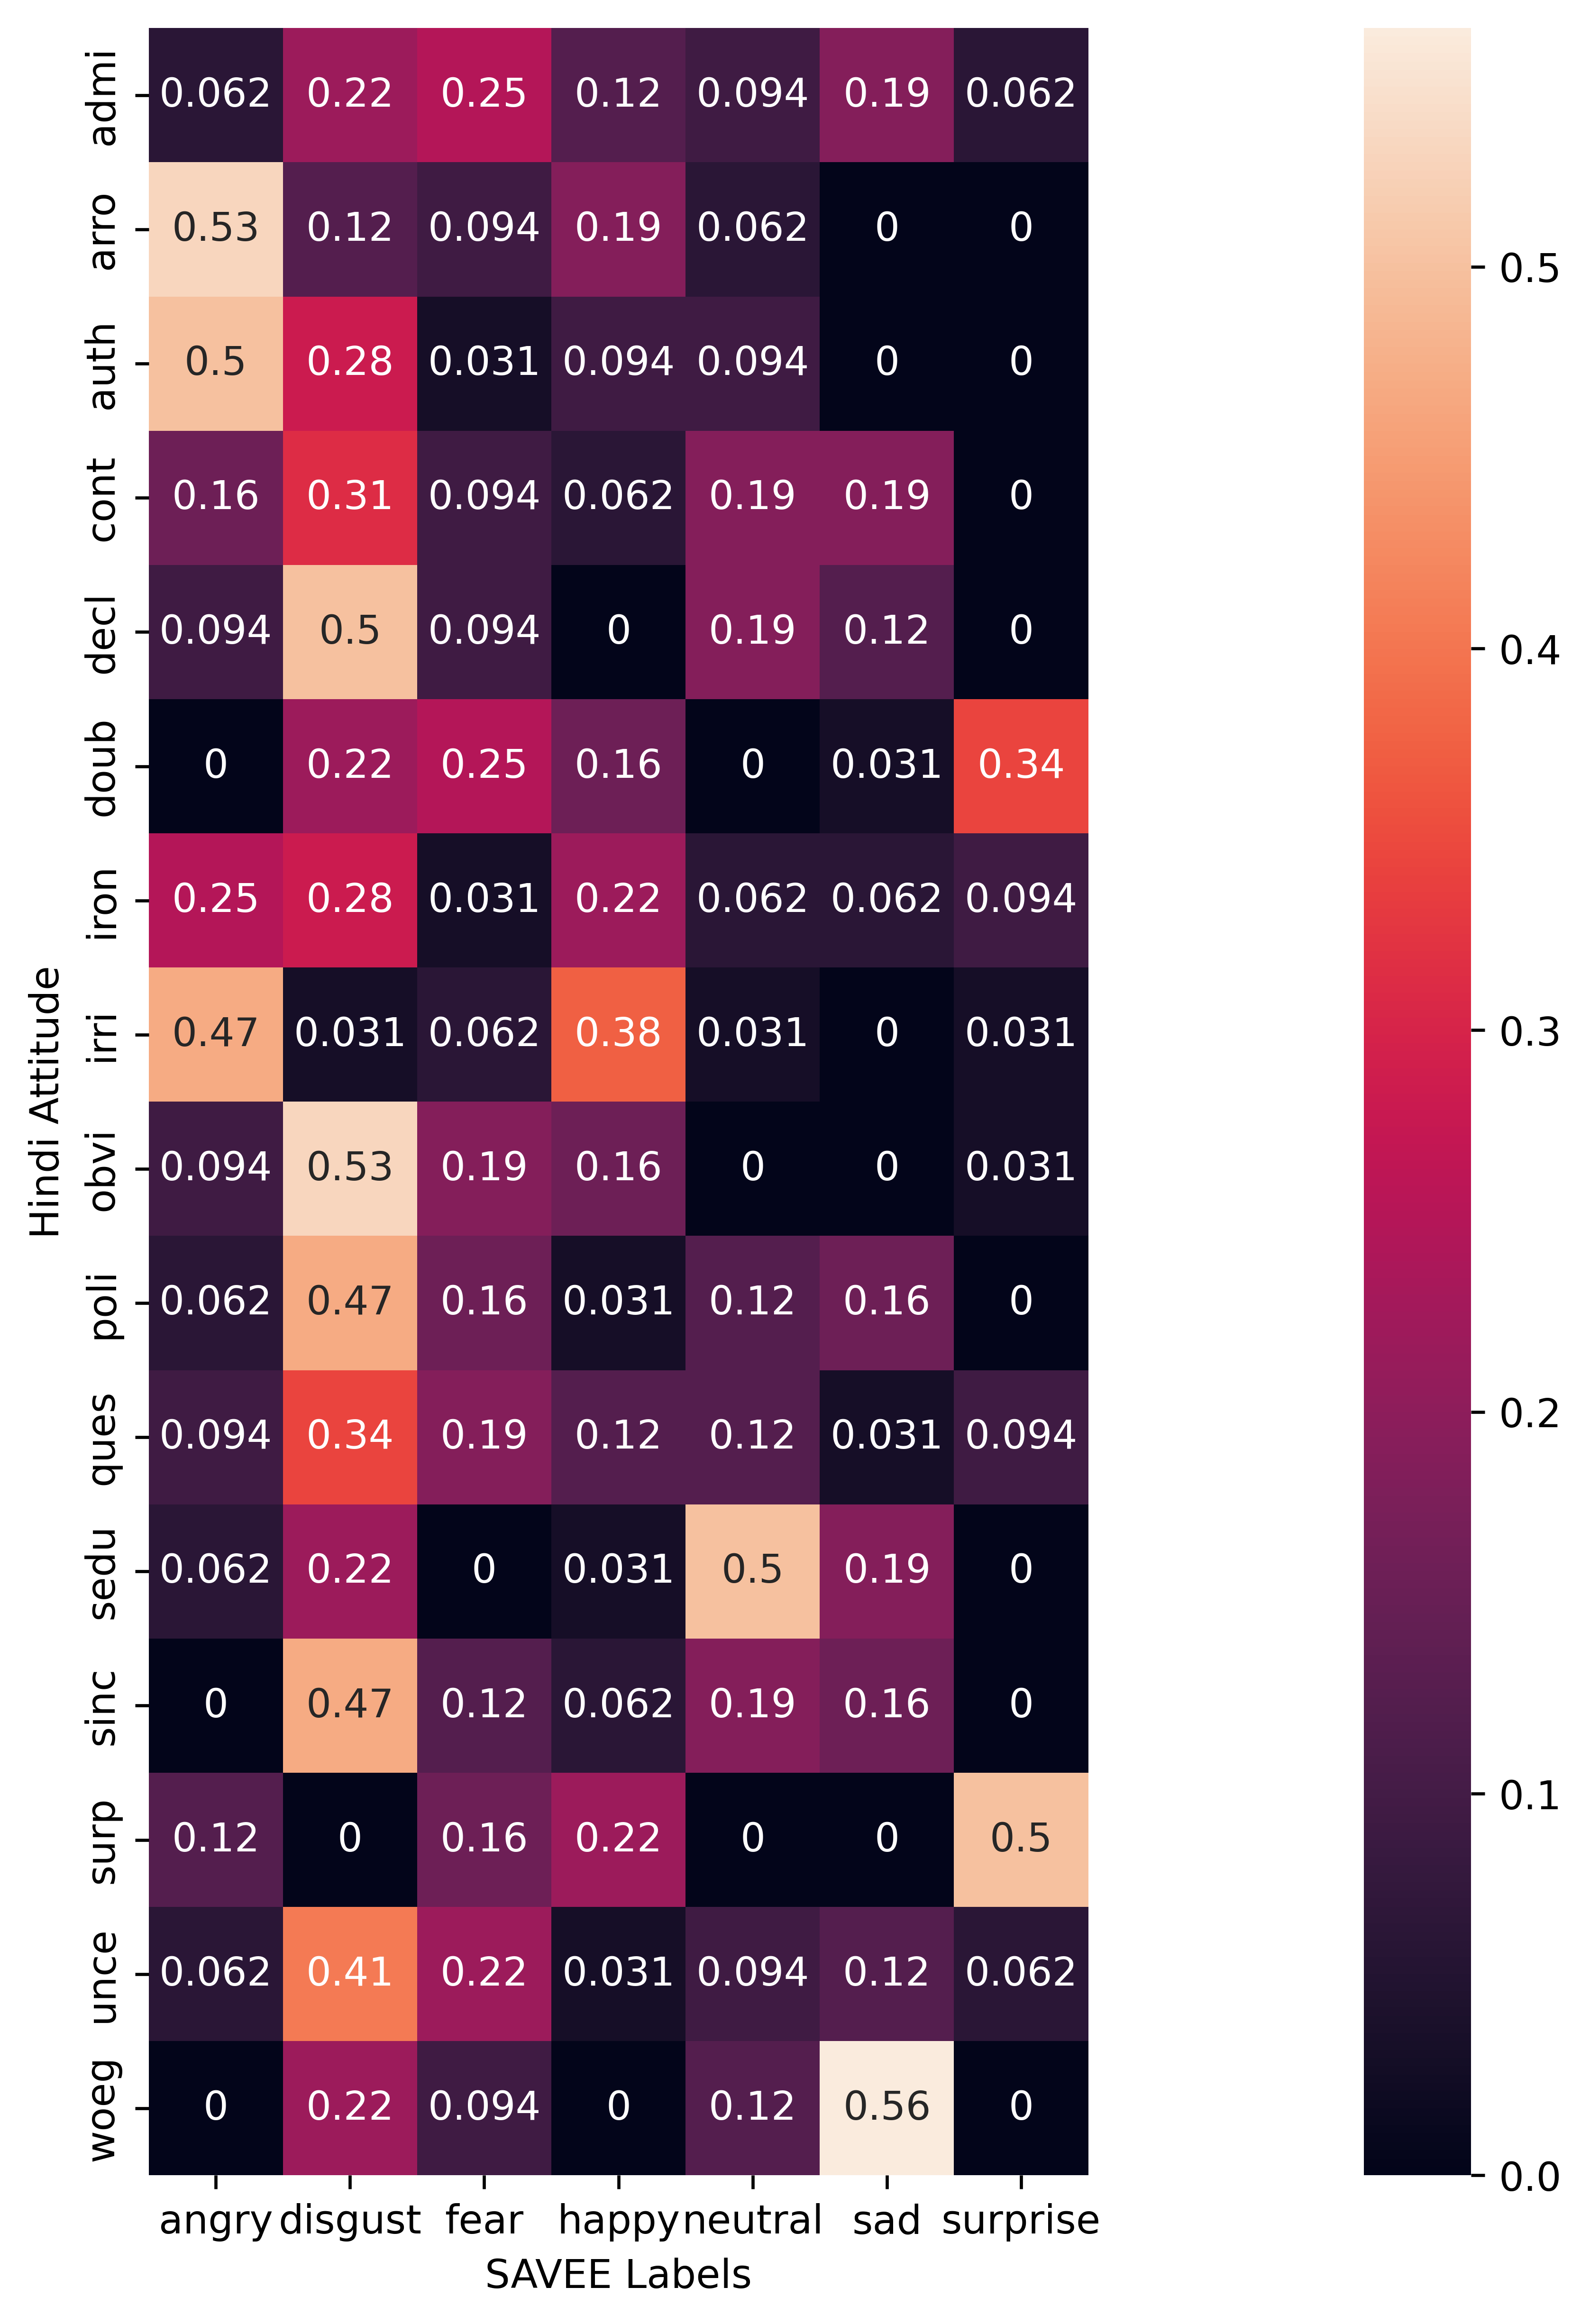

In [97]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(25,10))
sns.heatmap(df_labels_new_god_im_done_please_son_of_holyness/df_labels_new_god_im_done_please_son_of_holyness.sum(axis=1)[:, np.newaxis],square= True, annot=True)
plt.savefig("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\figures\\final_grouping_hindi_to_savee.png")

# RAVDESS Dataset

We wish to classify the RAVDESS Dataset based on the SAVEE ensemble LOSO models.
First, we load the SVM models trianed on the SAVEE dataset using the LOSO method

In [216]:
import importlib
import utils as utils
importlib.reload(utils)

<module 'utils' from 'd:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\code\\utils.py'>

In [22]:
trained_savee_model_ensemble = utils.load_svm_ensemble(model_path=r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\")

Loading model with DC left out while training
Loading model with JE left out while training
Loading model with JK left out while training
Loading model with KL left out while training


Loading the eGEMAPS features of the RAVDESS dataset. We also load the actor(speaker) identity and the file names. The file names have to be processed per dataset since the structure for the same is different. It encodes the emotion, utterance and other labels of the data.

In [203]:
X_ravdess, speaker, file_name, _ = utils.load_wav_features("C:\\Users\\HP\\Downloads\\Ravdess\\audio_speech_actors_01-24")

We now process the file names to extract the emotions and the utterances for each

In [204]:
emotions, utterances= utils.process_ravdess(file_name)

In [205]:
scaler = utils.StandardScaleNormalizer()
X_ravdess_norm = scaler.fit_transform(X_ravdess, speaker)

In [235]:
dataLoader = utils.CustomDataLoader(X_ravdess_norm, speaker, emotions, utterances)

In [239]:
from sklearn.model_selection import GridSearchCV
train_accuracy_list = []
test_accuracy_list = []
logo = utils.leave_one_speaker_out(dataLoader)
for data_train, data_test, emotion_train, emotion_test, utt_train, utt_test, speaker_train, speaker_test in iter(logo):
    print("Training with " + speaker_test[0] +" left out...")
    ml = svm.SVC() 
    
    # defining parameter range



    param_grid = {'C': [ 1, 10, 100, 1000,10000], 
                'gamma': [5,1,0.1,0.01,0.001,0.0001],
                'kernel': ['rbf']} 

    
    grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
    
    # fitting the model for grid search
    grid_search=grid.fit(data_train, emotion_train)
    y_test_hat=grid_search.predict(data_test)
    test_accuracy=accuracy_score(emotion_test,y_test_hat)*100
    accuracy = grid_search.best_score_ *100
    print("Accuracy for training dataset with tuning is : {:.2f}% and test accuracy : {:.2f}".format(accuracy, test_accuracy) )
    train_accuracy_list.append(accuracy)
    test_accuracy_list.append(test_accuracy)

Training with Actor_01 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for training dataset with tuning is : 64.57% and test accuracy : 48.33
Training with Actor_02 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for training dataset with tuning is : 62.17% and test accuracy : 85.00
Training with Actor_03 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for training dataset with tuning is : 62.68% and test accuracy : 68.33
Training with Actor_04 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for training dataset with tuning is : 63.48% and test accuracy : 46.67
Training with Actor_05 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for training dataset with tuning is : 62.32% and test accuracy : 68.33
Training with Actor_06 left out...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Accuracy for

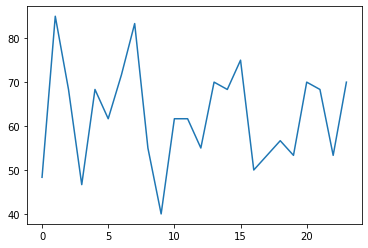

In [240]:
plt.plot(test_accuracy_list)


In [58]:
prob_sum_ravdess = trained_savee_model_ensemble[0].predict_proba(X_ravdess_norm)
for i in range(1, 4):
    prob_sum_ravdess+=trained_savee_model_ensemble[i].predict_proba(X_ravdess_norm)
prob_sum_ravdess /=4.0

In [61]:
labels_SAVEE = np.sort(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
predictions_ravdess = [labels_SAVEE[i] for i in np.argmax(prob_sum_ravdess, axis=1)]

In [63]:
df_labels_new = pd.DataFrame()
df_labels_new["RAVDESS"] = emotions
df_labels_new["SAVEE Labels"] = predictions_ravdess
df_cross_frequency = pd.crosstab(df_labels_new["RAVDESS"], df_labels_new["SAVEE Labels"])

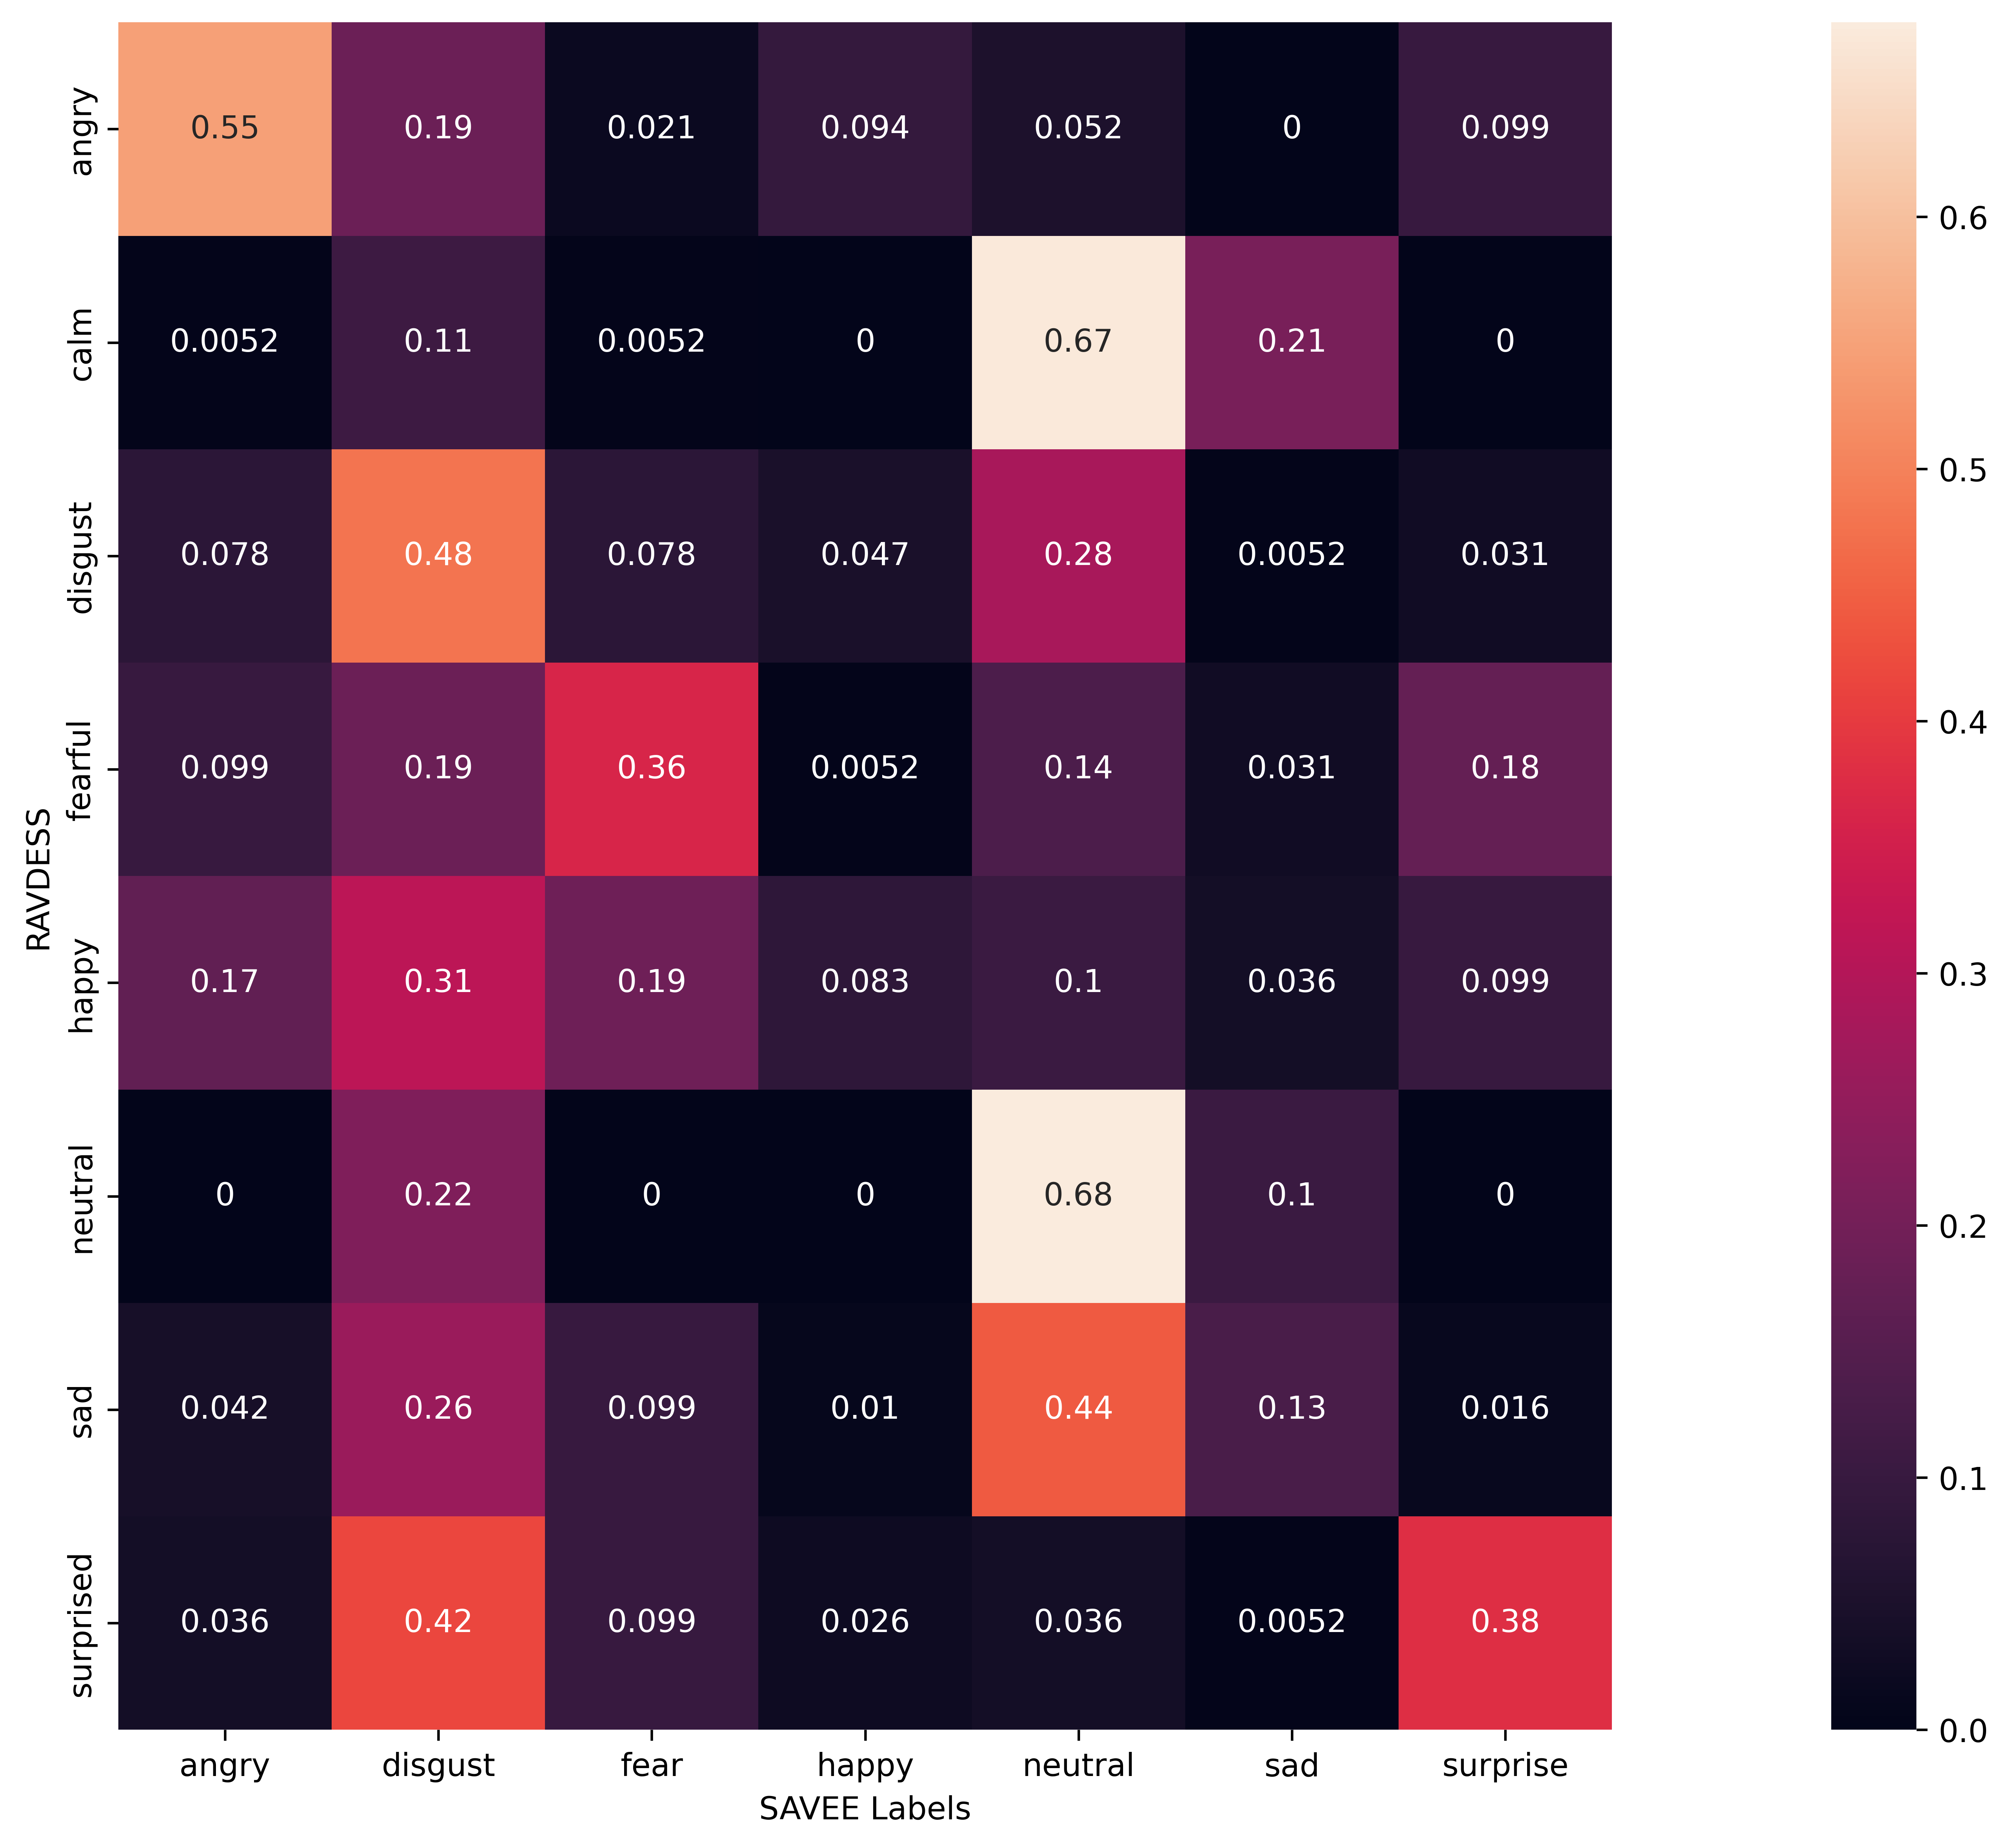

In [68]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(25,10))
sns.heatmap(df_cross_frequency/df_cross_frequency.sum(axis=1)[:, np.newaxis],square= True, annot=True)
plt.savefig("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\figures\\final_grouping_ravdess_to_savee.png")

# Practice

In [41]:
import subprocess

def generate_features_with_opensmile(wav_file, output_file_csv, config_file, frame_rate, step_size,voicing_threshold):
    # Create a temporary output file path
    
    config_file_actual = config_file.rsplit('.', 1)[0] +"_copy."+config_file.rsplit('.', 1)[1]
    
    # Update the frame rate and step size in the config file
    with open(config_file, 'r') as file, open(config_file_actual, 'w') as output_file:
        # config_content = file.read()
        for line in file:
            if line.startswith("frameSize = "):
                line =  "frameSize = "+str(step_size) + "\n"
                output_file.write(line)
            elif line.startswith("frameStep = "):
                line = "frameStep = " + str(frame_rate) + "\n"
                output_file.write(line)
            elif line.startswith("voicingCutoff = "):
                line = "voicingCutoff = " + str(voicing_threshold) + "\n"
                output_file.write(line)
            else:
                output_file.write(line)
    
    # config_content = config_content.replace("frameSize = ", "frameSize = "+str(frame_rate))
    # config_content = config_content.replace("STEP_SIZE_VALUE", str(step_size))
    # # config_content = config_content.replace("VOICING_THRESHOLD_VALUE", str(voicing_threshold))
    
    # with open(config_file, "w") as file:
    #     file.write(config_content)
    
    # # Run OpenSmile command to generate features
    command_cwd = "C:\\Users\\HP\\Downloads\\opensmile\\opensmile-3.0.1-win-x64\\bin\\"
    command = f".\SMILExtract -C {config_file_actual} -I {wav_file} -O {output_file_csv}"
    subprocess.run(command, shell=True, check=True, cwd = command_cwd)
    
    # # Read the generated features from the output file
    features = []
    with open(output_file_csv, "r") as file:
        lines = file.readlines()
        # Skip the header line
        for line in lines[1:]:
            # Split the line into values and convert to float
            values = [float(value) for value in line.strip().split(";")]
            features.append(values)
    
    # # Remove the temporary output file
    # subprocess.run(f"rm {output_file}", shell=True)
    
    return features

# Usage example
wav_file = "C:\\Users\\HP\\Downloads\\Ravdess\\audio_speech_actors_01-24\\Actor_24\\03-01-05-01-01-02-24.wav"
output_file_csv = "C:\\Users\\HP\\Downloads\\output.csv"
config_file = r"C:\Users\HP\Downloads\opensmile\opensmile-3.0.1-win-x64\config\demo\demo3.conf"
step_size = 0.05
frame_rate = 0.01
voicing_threshold = 0.45

ff = generate_features_with_opensmile(wav_file, output_file_csv, config_file, frame_rate, step_size, voicing_threshold)



In [42]:
ff

[[0.0, 0.0, 0.0, 0.0],
 [1.0, 0.01, 0.0, 0.0],
 [2.0, 0.02, 0.0, 0.0],
 [3.0, 0.03, 0.0, 0.0],
 [4.0, 0.04, 0.0, 0.0],
 [5.0, 0.05, 0.0, 0.0],
 [6.0, 0.06, 0.0, 0.0],
 [7.0, 0.07, 0.0, 0.0],
 [8.0, 0.08, 0.0, 0.0],
 [9.0, 0.09, 0.0, 0.0],
 [10.0, 0.1, 0.0, 0.0],
 [11.0, 0.11, 0.0, 0.0],
 [12.0, 0.12, 0.0, 0.0],
 [13.0, 0.13, 0.0, 0.0],
 [14.0, 0.14, 0.0, 0.0],
 [15.0, 0.15, 0.0, 0.0],
 [16.0, 0.16, 0.0, 0.0],
 [17.0, 0.17, 0.0, 0.0],
 [18.0, 0.18, 0.0, 0.0],
 [19.0, 0.19, 0.0, 0.0],
 [20.0, 0.2, 0.0, 0.0],
 [21.0, 0.21, 0.0, 0.0],
 [22.0, 0.22, 0.0, 0.0],
 [23.0, 0.23, 0.0, 0.0],
 [24.0, 0.24, 0.0, 0.0],
 [25.0, 0.25, 0.0, 0.0],
 [26.0, 0.26, 0.0, 0.0],
 [27.0, 0.27, 0.0, 0.0],
 [28.0, 0.28, 0.0, 0.0],
 [29.0, 0.29, 0.0, 0.0],
 [30.0, 0.3, 0.0, 0.0],
 [31.0, 0.31, 0.0, 0.0],
 [32.0, 0.32, 0.0, 0.0],
 [33.0, 0.33, 0.0, 0.0],
 [34.0, 0.34, 0.0, 0.0],
 [35.0, 0.35, 0.0, 0.0],
 [36.0, 0.36, 0.0, 0.0],
 [37.0, 0.37, 0.0, 0.0],
 [38.0, 0.38, 0.0, 0.0],
 [39.0, 0.39, 0.0, 0.0],
 [40.0, 0.4, 0

In [43]:
pitch = [i[-1] for i in ff]
time = [i[-3] for i in ff]


In [44]:
time

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.13,
 1.14,
 1.15,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27,
 1.28,
 1.29,
 1.3,
 1.31,
 1.32,
 1.33,
 1.34,
 1.35,
 1.36,
 1.37,
 1.38,
 1.39,
 1.4,
 1.41,
 1.42,
 1.43,
 1.44,


In [48]:
pathtoPraatInfo = r"C:\Users\HP\Downloads\info_pitch.txt"

In [49]:
pitchpraat = []
timepraat = []
with open(pathtoPraatInfo, "r") as file:
    lines = file.readlines()
    for line in lines[1:]:
        pitchinfo = line.strip().split()[-1]
        if pitchinfo=='--undefined--':
            pitchinfo=0
        pitchpraat.append(float(pitchinfo))
        timepraat.append(float(line.strip().split()[0]))
    

Text(0.5, 1.0, 'Praat')

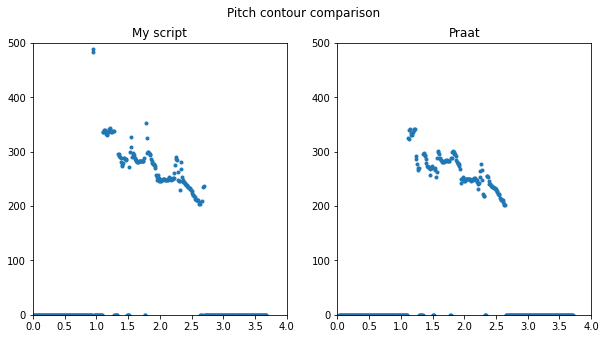

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.suptitle("Pitch contour comparison")
plt.subplot(121)
plt.plot(time,pitch, '.')
plt.title("My script")
plt.ylim(0, 500)
plt.xlim(0, 4)
plt.subplot(122)
plt.plot(timepraat, pitchpraat, '.')
plt.ylim(0, 500)
plt.xlim(0, 4)
plt.title("Praat")
